In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import rescale, resize, radon, iradon
from skimage.filters import gaussian
import scipy
from scipy.signal import argrelextrema
from scipy.interpolate import CubicSpline
from scipy.optimize import root, leastsq
from PIL import Image
import sys
from utils import add_noise, snr_calc, DC_and_SYM, fit
import h5py

/raid/home/everett/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/raid/home/everett/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [173]:
#h_sino = h5py.File('./sinograms/tomo_00001/tomo_00001.h5', 'r')
h_sino = h5py.File('./sinograms/tomo_00064_to_00067/tomo_00067.h5', 'r')
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))
h_sino.visititems(print_attrs)
data = h_sino['/exchange/data'][()]
theta = h_sino['/exchange/theta']
print(theta)

exchange
exchange/data
    units: b'counts'
    axes: b'theta:y:x'
    description: b'transmission'
exchange/data_dark
    units: b'counts'
    axes: b'theta_dark:y:x'
exchange/data_white
    units: b'counts'
    axes: b'theta_white:y:x'
exchange/theta
    units: b'degrees'
exchange/title
implements
measurement
measurement/instrument
measurement/instrument/acquisition
measurement/instrument/acquisition/comment
measurement/instrument/acquisition/mode
measurement/instrument/detector
measurement/instrument/detector/x_actual_pixel_size
    units: b'microns'
measurement/instrument/detector/y_actual_pixel_size
    units: b'microns'
measurement/instrument/monochromator
measurement/instrument/monochromator/energy
    units: b'keV'
measurement/instrument/source
measurement/instrument/source/beamline
measurement/instrument/source/current
    units: b'mA'
measurement/instrument/source/datetime
measurement/instrument/source/mode
measurement/instrument/source/name
measurement/sample
measurement/sam

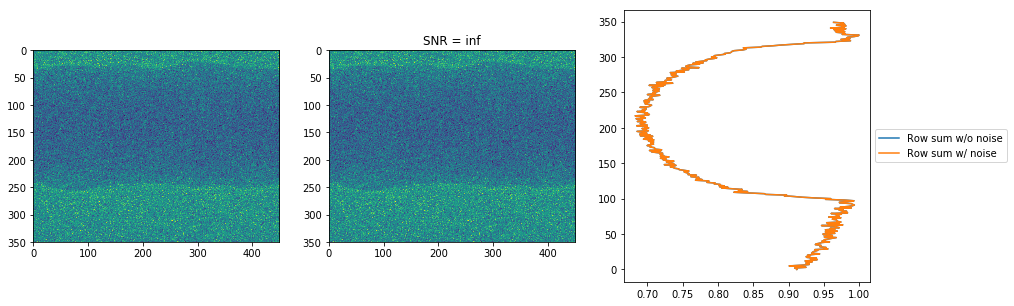

70
inf


In [294]:
exposure = .1
#clip = 10000
#sinogram = np.clip(np.load('sinogram_off_center.npy'),clip, None)
added = np.sum(add_noise(data,exposure)[0],axis = 1)
sinogram = np.transpose(added)
#sinogram = np.transpose(data[:,100,:])
#added_noise = add_noise(sinogram, exposure)
sinogram_noise = sinogram#added_noise[0]
sinogram_noise_snr = added_noise[1]

rowsum = np.sum(sinogram, axis=1)
rowsum_n = np.sum(sinogram_noise, axis=1)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(sinogram)
plt.subplot(132)
plt.imshow(sinogram_noise)
plt.title('SNR = ' + str(sinogram_noise_snr)[0:4])
plt.subplot(133)
plt.plot(rowsum[::-1]/np.max(rowsum), np.arange(0,sinogram.shape[0],1), label = 'Row sum w/o noise')
plt.plot(rowsum_n[::-1]/np.max(rowsum_n), np.arange(0,sinogram.shape[0],1), label = 'Row sum w/ noise')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

print(np.max(sinogram))
print(sinogram_noise_snr)

# Shift the Detector

/raid/home/everett/rotationcenter/utils.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  snr = np.mean(array)/np.std(noise-array)


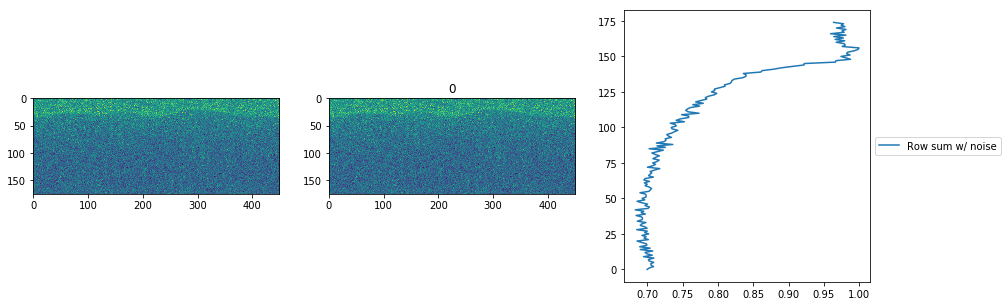

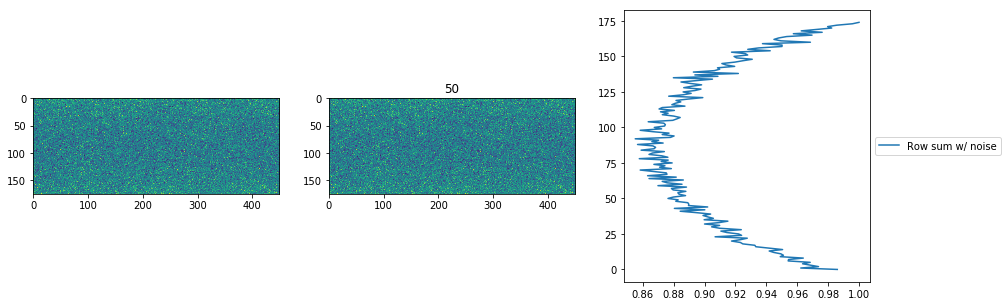

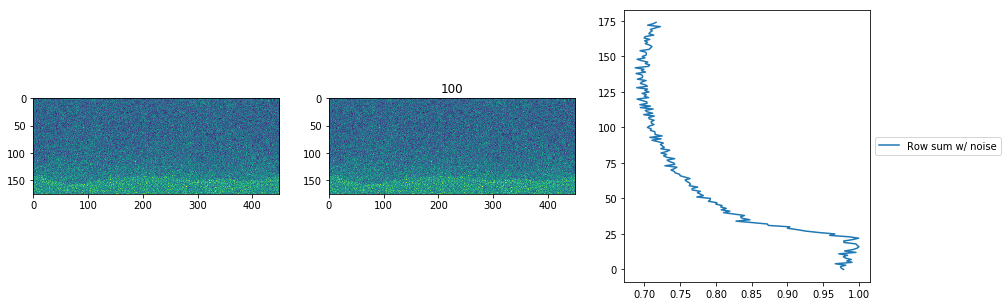

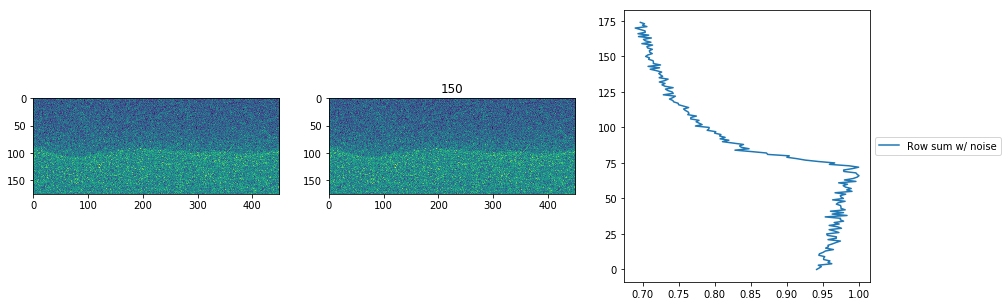

18943.0


In [295]:
DC_even = []
SYM_even= []
DC_odd = []
SYM_odd = []
DC_all = []
SYM_all = []
j = iter(list(range(50)))

scan_area = 175
shifting_range = sinogram.shape[0]-scan_area
for i in range(shifting_range):
    #shift sinogram so rotation center is off of image center and add noise
    #sinogram_shift_noiseless = np.clip(np.zeros((int(sinogram.shape[0]*2-256),sinogram.shape[1])),clip,None)
    #sinogram_shift_noiseless[100:100+sinogram.shape[0],:] = sinogram

    #sinogram_shift = add_noise(sinogram_shift_noiseless, exposure, bit_depth = 8)[0][i:i+450,:]
    sinogram_shift = add_noise(sinogram[i:i+scan_area,:], None)[0]
    
    #Sum sinogram along rows.
    #rowsum = np.sum(sinogram_shift_noiseless, axis=1, dtype=np.float64)
    rowsum_noise = np.sum(sinogram_shift, axis=1, dtype=np.float64)
    
    
    #Extract DC and SYM frequencies
    DC, SYM = DC_and_SYM(rowsum_noise)
    
    DC_all.append(DC)
    SYM_all.append(SYM)
    #Extract even and odd parts of DC and SYM.
    DC_even.append(np.real(DC))
    SYM_even.append(np.real(SYM))
    DC_odd.append(np.imag(DC))
    SYM_odd.append(np.imag(SYM))

    #Plotting
    if i %50==0:
        a = next(j)
        plt.figure(figsize=(15,5))
        plt.subplot(131)
        plt.imshow(sinogram_shift)
        plt.subplot(132)
        plt.imshow(sinogram_shift)
        plt.title(str(a*50))
        plt.subplot(133)
        #plt.plot((rowsum/np.max(rowsum))[::-1], np.arange(0,sinogram_shift.shape[0],1), label = 'Row sum w/o noise')
        plt.plot((rowsum_noise/np.max(rowsum_noise))[::-1], np.arange(0,sinogram_shift.shape[0],1), label = 'Row sum w/ noise')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        #plt.title('Entropy = ' + str(entropy)[0:10])
        plt.show()
    
plt.show()
print(np.max(rowsum_noise))


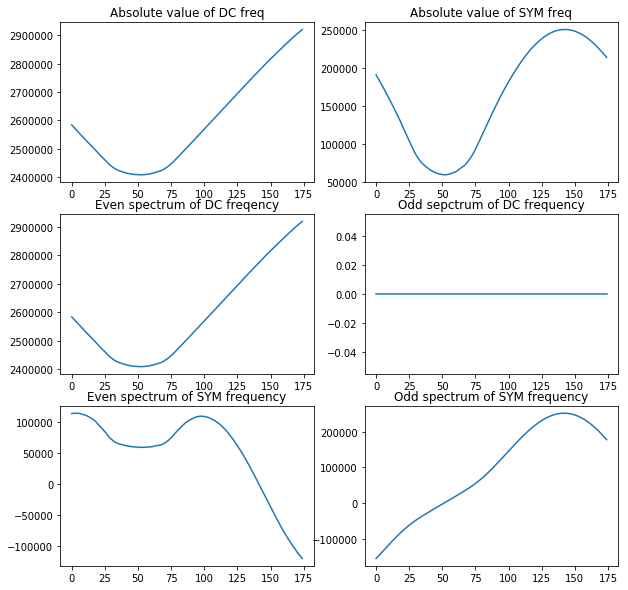

int64 70 12


In [296]:
plt.figure(figsize=(10,10))
plt.subplot(321)
plt.plot(np.abs(DC_all))
plt.title('Absolute value of DC freq')
plt.subplot(322)
plt.plot(np.abs(SYM_all))
plt.title('Absolute value of SYM freq')
plt.subplot(323)
plt.title('Even spectrum of DC freqency')
plt.plot(DC_even)
plt.subplot(324)
plt.title('Odd sepctrum of DC frequency')
plt.plot(DC_odd)

plt.subplot(325)
plt.title('Even spectrum of SYM frequency')
plt.plot(SYM_even)
plt.subplot(326)
plt.title('Odd spectrum of SYM frequency')
plt.plot(SYM_odd)

plt.show()

print(sinogram_shift.dtype, np.max(sinogram_shift), np.min(sinogram_shift))

# Fit odd imag component to sine curve

[50.84830594]
Estimated root =  [138.34830594]


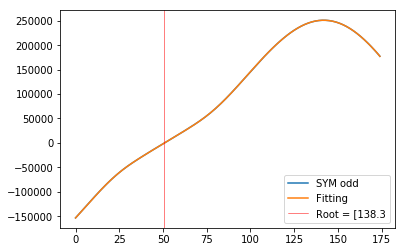

In [297]:
x = len(SYM_odd)
N = np.arange(x)


Ep = np.polyfit(N,SYM_odd,15)
fitted = np.poly1d(Ep)
root = np.real([a for a in np.roots(fitted.coef) if np.imag(a) == 0 and 0.<=np.real(a)<=x])[::-1]
print(root)
print('Estimated root = ',root+scan_area/2)


plt.figure()
plt.plot(N,SYM_odd, label = 'SYM odd')
plt.plot(N,fitted(N), label = 'Fitting')
plt.axvline(root[0], color='r', linewidth = '.5', label = 'Root = ' + str(root+scan_area/2)[0:6])
plt.legend()
plt.show()



In [298]:
#x_range = np.linspace(0,N, 1)
#fit = est_amp*np.sin(est_freq*x_range+est_phase)+est_mean


#fft_odd_max = argrelextrema(abs(data_fit), np.greater)[0]
fft_odd_imag_min = argrelextrema(abs(np.asarray(SYM_odd)), np.less)[0]

#print('True Center: ', sinogram.shape[0]/2+ 100)
#print('Odd real minimum: ', sinogram_shift.shape[0]/2 + fft_odd_max)
print('Odd imag minimum: ', fft_odd_imag_min+scan_area/2)

Odd imag minimum:  [138.5]


In [299]:
y = np.load('rowsum.npy')[::-1]
x = np.linspace(0,len(y),len(y))
ffty = np.fft.fft(y)

odd_comp = np.zeros(ffty.shape)+0.j
even_comp = np.real(ffty)
#odd_comp = np.imag(ffty)
odd_comp[1] = ffty[1]


plt.axvline(x=350, color='black', linewidth=1)
plt.axhline(y=0, color = 'black', linewidth=1)
plt.plot(y, label = 'Feature')
plt.plot(np.real(np.fft.ifft(even_comp)), label = 'Even Component')
plt.plot(-np.imag(np.fft.ifft(odd_comp)), label = 'Odd Component')
plt.yticks([])
plt.xticks([])
#plt.legend()
plt.show()



'''
x = np.linspace(-1,len(y/2),len(y/2))
ffty = np.fft.fft(y[0:int(len(y)/2)])

even_comp = np.real(ffty)
odd_comp = np.imag(ffty)

feature = y[0:int(len(y)/2)]

plt.plot(feature, label = 'Feature')
plt.plot(np.real(np.fft.ifft(even_comp)), label = 'Even Component')
plt.plot(-np.imag(np.fft.ifft(odd_comp)), label = 'Odd Component')
plt.legend()
plt.show()
'''

FileNotFoundError: [Errno 2] No such file or directory: 'rowsum.npy'

[-24184]


ValueError: x and y must have same first dimension, but have shapes (199,) and (1,)

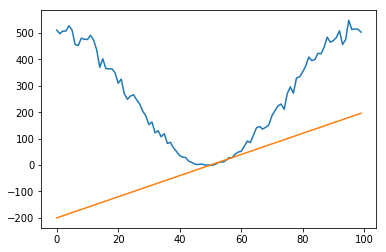

In [414]:
from scipy import signal
from skimage import restoration

sq = np.zeros(100)
sq[0:50]=255
sq[51:100]=-255
sq = (np.arange(100)-50)*4
curve = np.random.poisson(((np.sin(np.arange(100)/(5*np.pi)+np.pi*10/4+.01)))*255+255)
curve2 = np.arange(100)*255/100#(np.cos(np.arange(100)/(10*np.pi)+150)**2)

conv = np.correlate(sq,curve)#, mode = 'full')
print(conv)
plt.plot(curve)
plt.plot(sq)
plt.plot(np.arange(199)/2, conv[::-1])#*10/np.max(conv))
plt.show()

In [409]:
xc = 199
Nc = np.arange(xc)


Epc = np.polyfit(Nc,conv,15)
fittedc = np.poly1d(Epc)
rootc = np.real([a for a in np.roots(fittedc.coef) if np.imag(a) == 0 and 0.<=np.real(a)<=x])[::-1]
print(100-rootc[1]/2)

TypeError: expected x and y to have same length

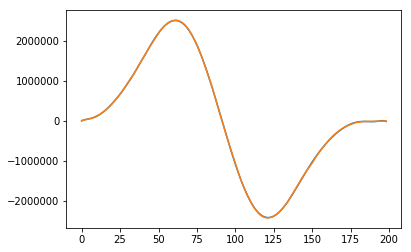

In [266]:
plt.plot(fittedc(Nc))
plt.plot(conv)
plt.show()